In [1]:
import torch
import utils
import constants
from dataset import prepare_dataloader

utils.set_seed(42)
parser = utils.get_parser()

opt = parser.parse_args(args=['-data', 
                              'data_sep/', 
                              '-n_layers', '2',
                              '-batch_size', '16', '-d_model', '32', "-d_inner_hid", '64', '-n_head', '2', '-lr', '1e-4',
                              '-model', 'cstpp', '-n_comps', '2', '-epoch', '10', '-device', '0'])
if torch.cuda.is_available() and opt.device != -1:
    opt.device = torch.device('cuda:' + str(opt.device))  
else:
    opt.device = torch.device('cpu')
print('[Info] parameters: {}'.format(opt))

trainloader, testloader, num_types = prepare_dataloader(opt)
time_scale = utils.get_time_scale(trainloader)
print('[Info] reloading data: scaling timestamps to {:.3f} times of the original'.format(1 / time_scale))
trainloader, testloader, num_types = prepare_dataloader(opt, time_scale)

batch = next(iter(trainloader)) # times, time intervals, markers, clusters

[2022-11-28 12:13:41,027.027 dsw43543-7f8448f5d4-d4j6q:22562 INFO utils.py:30] NOTICE: PAIDEBUGGER is turned off.


[Info] parameters: Namespace(agg='attn', batch_size=16, d_inner_hid=64, d_k=16, d_model=32, d_v=16, data='data_sep/', device=device(type='cuda', index=0), dropout=0.1, epoch=10, lr=0.0001, model='cstpp', n_comps=2, n_head=2, n_layers=2, smooth=0.1)
[Info] Loading train data...
[Info] Loading dev data...
[Info] Loading test data...
[Info] reloading data: scaling timestamps to 0.920 times of the original
[Info] Loading train data...
[Info] Loading dev data...
[Info] Loading test data...


In [2]:
times, intervals, markers, clusters = batch

In [3]:
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from models.eemb import EventEmb, TimeEncode
from models.tfm import TfmEnc, TfmEncLayer
from einops import rearrange, repeat

In [5]:
ee = EventEmb(d_model=32, marker_num=num_types)
# x = ee(times, markers)

In [6]:
# pad_mask = (markers == constants.PAD) # (b, s)
# attn_mask = torch.triu(torch.ones(x.shape[-2], x.shape[-2]), diagonal=1).bool() # (s, s)

In [7]:
class InferenceNetwork(nn.Module):
    # q(Z | X)
    def __init__(self, d_model, n_layer, n_head, K):
        super().__init__()
        self.enc = TfmEnc(n_layer, TfmEncLayer, d_model=d_model, n_head=n_head)
        self.lin = nn.Linear(d_model, K)
        
    def forward(self, x, pad_mask, attn_mask):
        h = self.enc(x, pad_mask, attn_mask) # (b, s, d)
        logits = self.lin(h) # (b, s, k)
        return logits
        
net = InferenceNetwork(d_model=32, n_layer=3, n_head=4, K=4)
# logits = net(x, pad_mask, attn_mask)

In [8]:
# z = F.gumbel_softmax(logits, tau=0.1, hard=True) # b, s, k

In [9]:
from models.ctfm import cTfmEnc, cTfmEncLayer
    
cte = cTfmEnc(n_layer=3, layer=cTfmEncLayer, d_model=32, n_head=4)
# o = cte(x, z, pad_mask, attn_mask)

In [11]:
# h_last, dt_last, first_event_mask = get_last_event_info(o, times, z)

-37.95624542236328 -124.83500671386719
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

-54.815467834472656 -150.63311767578125
-66.97294616699219 -164.8950958251953
-89.5050277709961 -168.28248596191406
-80.73877716064453 -166.86734008789062
-87.12181091308594 -169.20614624023438
-90.7705078125 -170.3634796142578
-89.52899169921875 -171.69744873046875
-86.95345306396484 -172.07424926757812
-69.29158020019531 -172.49728393554688
-83.3275146484375 -172.4024200439453
-77.62583923339844 -171.9908447265625
-76.7843017578125 -172.216064453125
-77.90499114990234 -172.33558654785156
-82.61210632324219 -172.21241760253906
-85.9842300415039 -172.51515197753906
-87.32313537597656 -172.60777282714844
-74.83595275878906 -172.833984375
-81.62506103515625 -172.79539489746094
-80.03946685791016 -172.9567413330078
-82.10260009765625 -173.0482940673828
-86.7380599975586 -173.070480

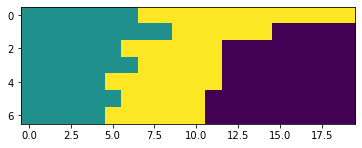

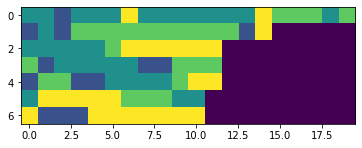

-79.59336853027344 -173.21189880371094
-72.92933654785156 -173.21652221679688
-81.1465835571289 -173.2121124267578
-95.42448425292969 -173.2140655517578
-82.6375503540039 -173.2145233154297
-90.51216125488281 -173.21664428710938
-83.67449951171875 -173.21820068359375
-84.84368133544922 -173.22622680664062
-83.27088928222656 -173.22634887695312
-76.85016632080078 -173.23110961914062
-81.65863037109375 -173.22500610351562
-83.53219604492188 -173.24183654785156
-75.67394256591797 -173.23545837402344
-89.25615692138672 -173.23324584960938
-83.93270111083984 -173.24032592773438
-80.31272888183594 -173.240234375
-86.23644256591797 -173.23757934570312
-74.93107604980469 -173.2465057373047
-81.24500274658203 -173.2428436279297
-88.19511413574219 -173.25714111328125
-80.3120346069336 -173.24412536621094
-83.5356216430664 -173.24478149414062
-79.20108795166016 -173.24891662597656
-87.49708557128906 -173.2451171875
-83.4881362915039 -173.25079345703125
-83.64766693115234 -173.25564575195312
-71.8

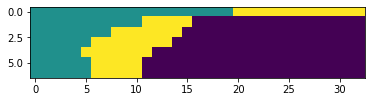

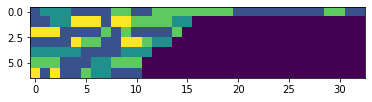

-84.5286865234375 -173.25735473632812
-90.98673248291016 -173.26161193847656
-85.15437316894531 -173.2595977783203
-79.46233367919922 -173.2605743408203
-82.09825897216797 -173.2623291015625
-89.79621887207031 -173.2627716064453
-77.18663024902344 -173.25779724121094
-80.91004943847656 -173.26524353027344
-84.85861206054688 -173.26266479492188
-79.26707458496094 -173.26324462890625
-89.64137268066406 -173.26422119140625
-83.95836639404297 -173.26675415039062
-79.83321380615234 -173.2642364501953
-77.98109436035156 -173.26528930664062
-94.18531799316406 -173.26707458496094
-82.36016082763672 -173.2631072998047
-85.24708557128906 -173.26332092285156
-79.05668640136719 -173.26564025878906
-81.89241790771484 -173.26455688476562
-87.03507232666016 -173.26455688476562
-82.5381088256836 -173.2667236328125
-78.98948669433594 -173.26710510253906
-81.21324157714844 -173.2676544189453
-84.27183532714844 -173.2653045654297
-80.51765441894531 -173.26609802246094
-82.72166442871094 -173.265274047851

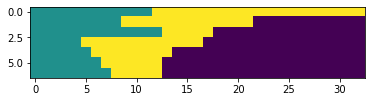

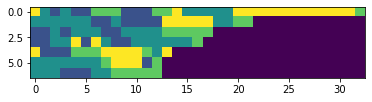

-93.18873596191406 -173.2711181640625
-70.25096130371094 -173.27197265625
-86.26139068603516 -173.2709503173828
-73.84867095947266 -173.26625061035156
-83.0107421875 -173.27171325683594
-76.59999084472656 -173.2705078125
-83.78005981445312 -173.2723388671875
-77.62001037597656 -173.26995849609375
-90.6938705444336 -173.26986694335938
-72.2602310180664 -173.27243041992188
-78.0279769897461 -173.27316284179688
-78.27638244628906 -173.27345275878906
-84.38350677490234 -173.271484375
-85.26234436035156 -173.2733612060547
-87.18269348144531 -173.27444458007812
-79.3616943359375 -173.27163696289062
-76.27997589111328 -173.2739715576172
-83.51661682128906 -173.2760009765625
-98.71719360351562 -173.27357482910156
-84.32950592041016 -173.27406311035156
-80.1362533569336 -173.27508544921875
-88.14054870605469 -173.27520751953125
-85.20658874511719 -173.2759246826172
-69.76434326171875 -173.2733154296875
-90.64765930175781 -173.27500915527344
-91.36669921875 -173.27349853515625
-72.70376586914062

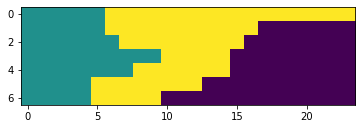

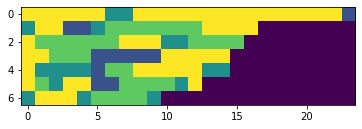

-83.66206359863281 -173.27499389648438
-74.65132141113281 -173.27676391601562
-76.18464660644531 -173.2774658203125
-78.16126251220703 -173.2776336669922
-79.0274429321289 -173.2775115966797
-77.72125244140625 -173.27674865722656
-92.55387878417969 -173.2781982421875
-88.81497955322266 -173.27684020996094
-87.19020080566406 -173.27792358398438
-74.29374694824219 -173.2779998779297
-87.11872863769531 -173.27760314941406
-84.09771728515625 -173.2778778076172
-66.25863647460938 -173.27780151367188
-78.68292236328125 -173.27850341796875
-74.21358489990234 -173.278076171875
-84.90213012695312 -173.27688598632812
-84.15731811523438 -173.2787322998047
-84.05595397949219 -173.27755737304688
-82.80656433105469 -173.27749633789062
-91.97310638427734 -173.27825927734375
-88.11506652832031 -173.27862548828125
-78.98228454589844 -173.2775115966797
-88.16490173339844 -173.27833557128906
-83.26436614990234 -173.27777099609375
-78.64170837402344 -173.27932739257812
-82.85249328613281 -173.2783203125
-

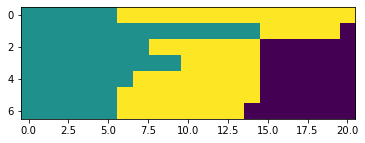

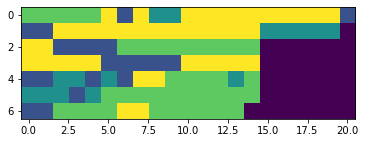

-94.04493713378906 -173.27951049804688
-82.04940795898438 -173.2791290283203
-87.52102661132812 -173.27944946289062
-81.38447570800781 -173.2805633544922
-64.14271545410156 -173.2801055908203
-101.23888397216797 -173.2799530029297
-86.63565063476562 -173.2801055908203
-75.10030364990234 -173.281494140625
-86.89921569824219 -173.28036499023438
-84.2678451538086 -173.28067016601562
-76.39894104003906 -173.28085327148438
-79.31505584716797 -173.27967834472656
-92.8611068725586 -173.2807159423828
-65.46448516845703 -173.28005981445312
-91.75153350830078 -173.28103637695312
-88.2625732421875 -173.2816925048828
-83.20073699951172 -173.28077697753906
-76.6143798828125 -173.2809295654297
-74.85919189453125 -173.28114318847656
-73.96348571777344 -173.28074645996094
-84.39973449707031 -173.28143310546875
-79.17356872558594 -173.2804718017578
-81.85481262207031 -173.28086853027344
-94.3910903930664 -173.281494140625
-79.41078186035156 -173.28086853027344
-73.13044738769531 -173.2801513671875
-79.

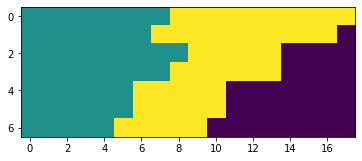

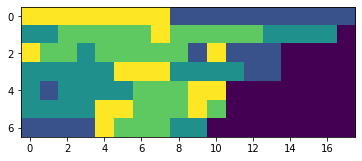

-87.87092590332031 -173.2818145751953
-83.36070251464844 -173.2821044921875
-87.01914978027344 -173.2823028564453
-75.47322082519531 -173.281982421875
-78.4078140258789 -173.2822723388672
-78.84677124023438 -173.2818603515625
-81.83927154541016 -173.2820281982422
-75.5289535522461 -173.2822265625
-85.74441528320312 -173.2816162109375
-89.6805191040039 -173.28208923339844
-73.39473724365234 -173.28219604492188
-75.76728820800781 -173.2818145751953
-85.66737365722656 -173.28207397460938
-86.26060485839844 -173.28248596191406
-78.58778381347656 -173.2817840576172
-79.23197174072266 -173.28221130371094
-78.37357330322266 -173.28216552734375
-71.35395812988281 -173.28155517578125
-88.36339569091797 -173.28289794921875
-87.40819549560547 -173.28201293945312
-68.89652252197266 -173.2827606201172
-82.5255355834961 -173.2830047607422
-84.1943588256836 -173.2821807861328
-72.51554870605469 -173.28233337402344
-91.82521057128906 -173.28175354003906
-91.88614654541016 -173.28289794921875
-76.96918

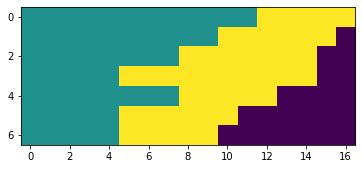

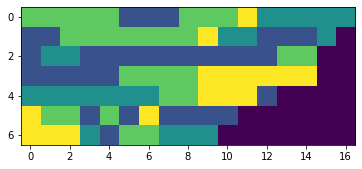

-84.27425384521484 -173.2824249267578
-88.0322036743164 -173.28309631347656
-72.44711303710938 -173.28250122070312
-88.62010192871094 -173.28358459472656
-87.06591796875 -173.28269958496094
-87.67158508300781 -173.28282165527344
-80.46861267089844 -173.28367614746094
-84.30447387695312 -173.28372192382812
-83.35848999023438 -173.28311157226562
-78.3833236694336 -173.28269958496094
-78.39514923095703 -173.28273010253906
-74.45677185058594 -173.28305053710938
-92.4013671875 -173.28359985351562
-79.46512603759766 -173.28306579589844
-75.51383209228516 -173.28358459472656
-79.91136169433594 -173.28250122070312
-66.98231506347656 -173.28314208984375
-78.40867614746094 -173.28309631347656
-96.32060241699219 -173.2832794189453
-80.88677978515625 -173.28294372558594
-83.67212677001953 -173.28382873535156
-84.22789001464844 -173.28343200683594
-80.48905944824219 -173.2838897705078
-72.15866088867188 -173.28370666503906
-89.05992126464844 -173.283447265625
-81.22773742675781 -173.2833251953125
-

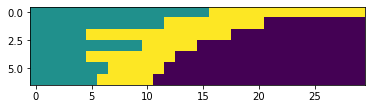

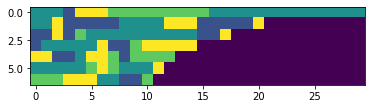

-74.24345397949219 -173.28396606445312
-77.85015869140625 -173.2837677001953
-76.89665222167969 -173.28353881835938
-87.83485412597656 -173.28366088867188
-77.60784149169922 -173.28334045410156
-81.86837768554688 -173.2838134765625
-75.44339752197266 -173.2845001220703
-84.91213989257812 -173.28282165527344
-89.5544204711914 -173.2837371826172
-83.97020721435547 -173.2837677001953
-86.58181762695312 -173.28419494628906
-76.27180480957031 -173.28395080566406
-81.91667175292969 -173.28347778320312
-76.61846923828125 -173.28363037109375
-90.50764465332031 -173.28314208984375
-79.4558334350586 -173.28390502929688
-84.33290100097656 -173.28363037109375
-81.84008026123047 -173.28404235839844
-74.38232421875 -173.28443908691406
-71.68575286865234 -173.28416442871094
-78.49488830566406 -173.28392028808594
-88.3342514038086 -173.2839813232422
-90.85245513916016 -173.28346252441406
-99.66278076171875 -173.2841339111328
-81.10649108886719 -173.282958984375
-76.02420806884766 -173.28321838378906
-

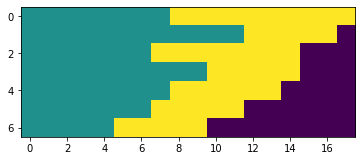

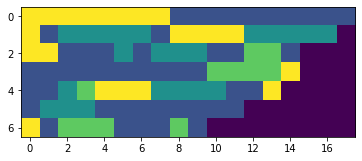

-69.38987731933594 -173.2843780517578
-80.91200256347656 -173.2840118408203
-83.03041076660156 -173.28382873535156
-84.11915588378906 -173.2843475341797
-78.41081237792969 -173.28369140625
-82.63700866699219 -173.2828826904297
-93.1399917602539 -173.28457641601562
-90.55018615722656 -173.28424072265625
-78.36624145507812 -173.2843780517578
-93.499755859375 -173.2843475341797
-76.91493225097656 -173.28460693359375
-69.9161605834961 -173.28416442871094
-81.56114196777344 -173.28421020507812
-85.47274017333984 -173.28392028808594
-81.41458129882812 -173.2840576171875
-87.44273376464844 -173.2838134765625
-85.04722595214844 -173.28466796875
-69.83799743652344 -173.28443908691406
-75.96022033691406 -173.2839813232422
-87.588623046875 -173.2841339111328
-82.6553955078125 -173.28456115722656
-87.15934753417969 -173.2843780517578
-75.6382064819336 -173.28451538085938
-90.80256652832031 -173.28440856933594
-83.4129867553711 -173.28463745117188
-79.42987823486328 -173.28396606445312
-84.87577056

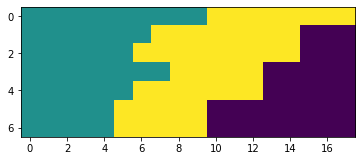

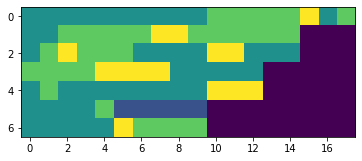

In [12]:
# o_last, t_last, t -> log_prob
from models.tpp import TPP

    
tpp = TPP(d_model=32, marker_num=num_types, device=opt.device)

import itertools
optimizer = optim.Adam(itertools.chain(
    list(ee.parameters()),
    list(net.parameters()),
    list(cte.parameters()),
    list(tpp.parameters()),
))

for epo in range(10):
    for times, _, markers, comps in trainloader:
        # encoder
        x = ee(times, markers)
        pad_mask = (markers == constants.PAD) # (b, s)
        attn_mask = torch.triu(torch.ones(x.shape[-2], x.shape[-2]), diagonal=1).bool() # (s, s)
        logits = net(x, pad_mask, attn_mask)

        # loss
        tpp_loss = []
        for i in range(5):
            # sampler
            z = F.gumbel_softmax(logits, tau=0.1, hard=True) # b, s, k

            # decoder
            h = cte(x, z, pad_mask, attn_mask)
            h_last, dt_last, first_event_mask = utils.get_last_event_info(h, times, z)
            tpp_loss.append(tpp.loss(h_last, dt_last, markers, first_event_mask | pad_mask))

        tpp_loss = torch.tensor(tpp_loss).mean()

        pi = F.softmax(logits, -1)
        kl = pi * torch.log(pi * opt.n_comps)
        kl = kl[~(first_event_mask | pad_mask)].mean()
        kl_loss = kl * 1000

        l = tpp_loss + kl_loss

        # optim
        optimizer.zero_grad()
        l.backward()
        print(tpp_loss.item(), kl_loss.item())
        optimizer.step()
    
    plt.imshow(comps); plt.show()
    res = logits.argmax(-1)
    res[pad_mask] = -1
    plt.imshow(res.detach()); plt.show()
